In [1]:
!pip install scattertext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9297 sha256=215de28704aa3504d7b75f93ad7057d2c8f34cfb521a998c6c327ce5b4fdc83b
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scattertext as st  # https://github.com/JasonKessler/scattertext
import spacy
from pprint import pprint
import IPython
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import plotly.express as px
import re

In [3]:
train_df = pd.read_csv("https://raw.githubusercontent.com/csabi0312/DeepLProject/main/train.csv",index_col=0)
train_df.head()

,prompt,A,B,C,D,E,answer
id,,,,,,,
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   prompt  200 non-null    object
 1   A       200 non-null    object
 2   B       200 non-null    object
 3   C       200 non-null    object
 4   D       200 non-null    object
 5   E       200 non-null    object
 6   answer  200 non-null    object
dtypes: object(7)
memory usage: 12.5+ KB


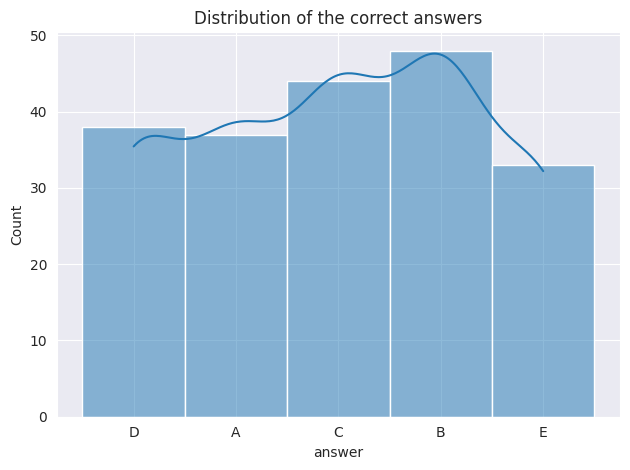

In [5]:
# Plot the distribution of the correct answers
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots()
    ax = sns.histplot(data=train_df, x='answer', kde=True)
    axs.set_title('Distribution of the correct answers')
    fig.tight_layout()
plt.show()

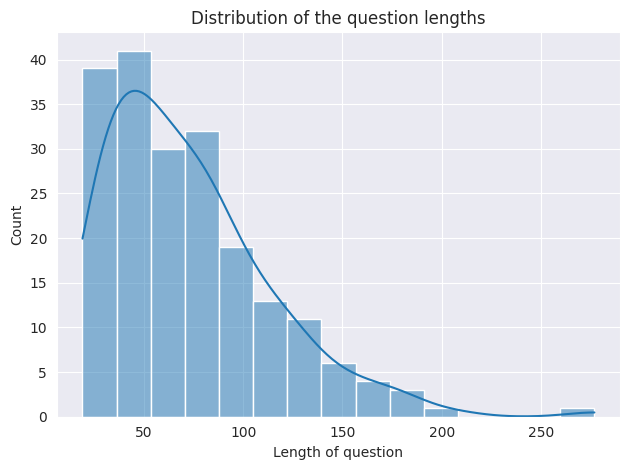

In [6]:
# Distribution of the question lengths
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots()
    ax = sns.histplot(train_df['prompt'].str.len(), kde=True, bins=15)
    axs.set_title('Distribution of the question lengths')
    axs.set_xlabel('Length of question')
    fig.tight_layout()
plt.show()

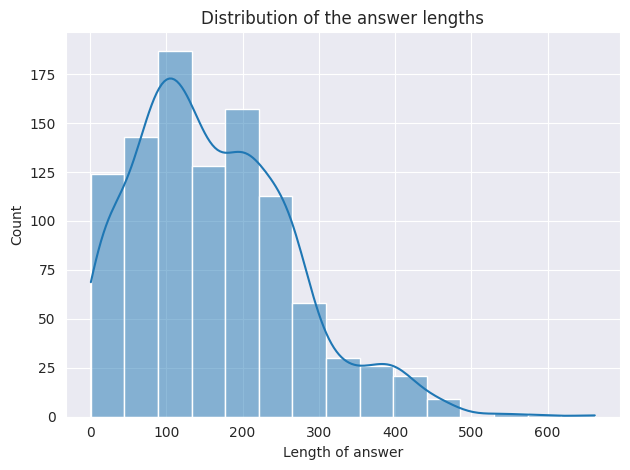

In [7]:
# Distribution of the answer lengths
word_len_df = pd.Series([], dtype=str)
for col in ['A','B','C','D','E']:
    word_len_df = pd.concat([word_len_df, train_df[col].str.len()], axis=0)

with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots()
    ax = sns.histplot(word_len_df, kde=True, bins=15)
    axs.set_title('Distribution of the answer lengths')
    axs.set_xlabel('Length of answer')
    fig.tight_layout()
plt.show()

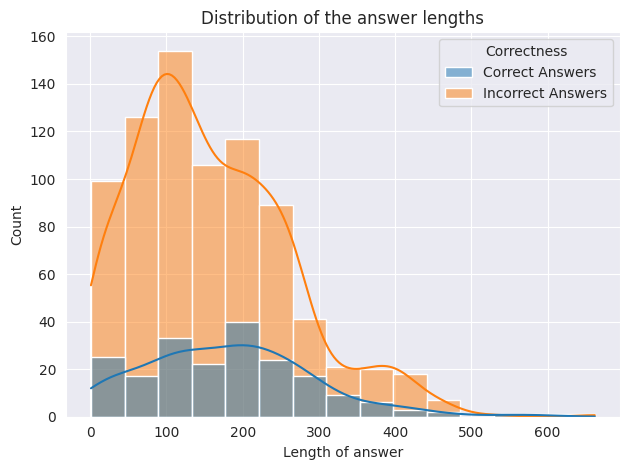

In [8]:
# Distribution of the correct answer lengths
# Create a series of all the answers
answers = pd.Series([], dtype=str)
for col in ['A','B','C','D','E']:
    answers = pd.concat([answers, train_df[col]], axis=0)

# Filter for the crrrect answers
correct_answers = train_df.apply(lambda x: x['A'] if x['answer']=='A' \
                                     else (x['B'] if x['answer']=='B' \
                                     else (x['C'] if x['answer']=='C' \
                                     else (x['D'] if x['answer']=='D' \
                                     else (x['E'] if x['answer']=='E' \
                                     else np.nan)))), axis=1)
# Get the remaining incorrect ones
incorrect_answers = answers[~answers.isin(correct_answers)]
# Reset the indices
correct_answers = correct_answers.reset_index(drop=True)
incorrect_answers = incorrect_answers.reset_index(drop=True)
# Create DataFrames for each Series
correct_df = pd.DataFrame({'Answer': correct_answers})
incorrect_df = pd.DataFrame({'Answer': incorrect_answers})

# Add a 'Series_Name' column to each DataFrame
correct_df['Correctness'] = 'Correct Answers'
incorrect_df['Correctness'] = 'Incorrect Answers'

# Add the questions to the dataframes
correct_df['Question'] = train_df['prompt']
questions = train_df['prompt'].repeat(4)
questions = questions.reset_index()['prompt']
incorrect_df['Question'] = questions

# Concatenate the DataFrames
answers_df = pd.concat([correct_df, incorrect_df], ignore_index=True)
# Get the answer length
answers_df['Answer Length'] = answers_df['Answer'].str.len()

# Plot their length distribution
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots()
    ax = sns.histplot(answers_df, x='Answer Length',  hue="Correctness", kde=True, bins=15)
    axs.set_title('Distribution of the answer lengths')
    axs.set_xlabel('Length of answer')
    fig.tight_layout()
plt.show()    # They show a similar distribution

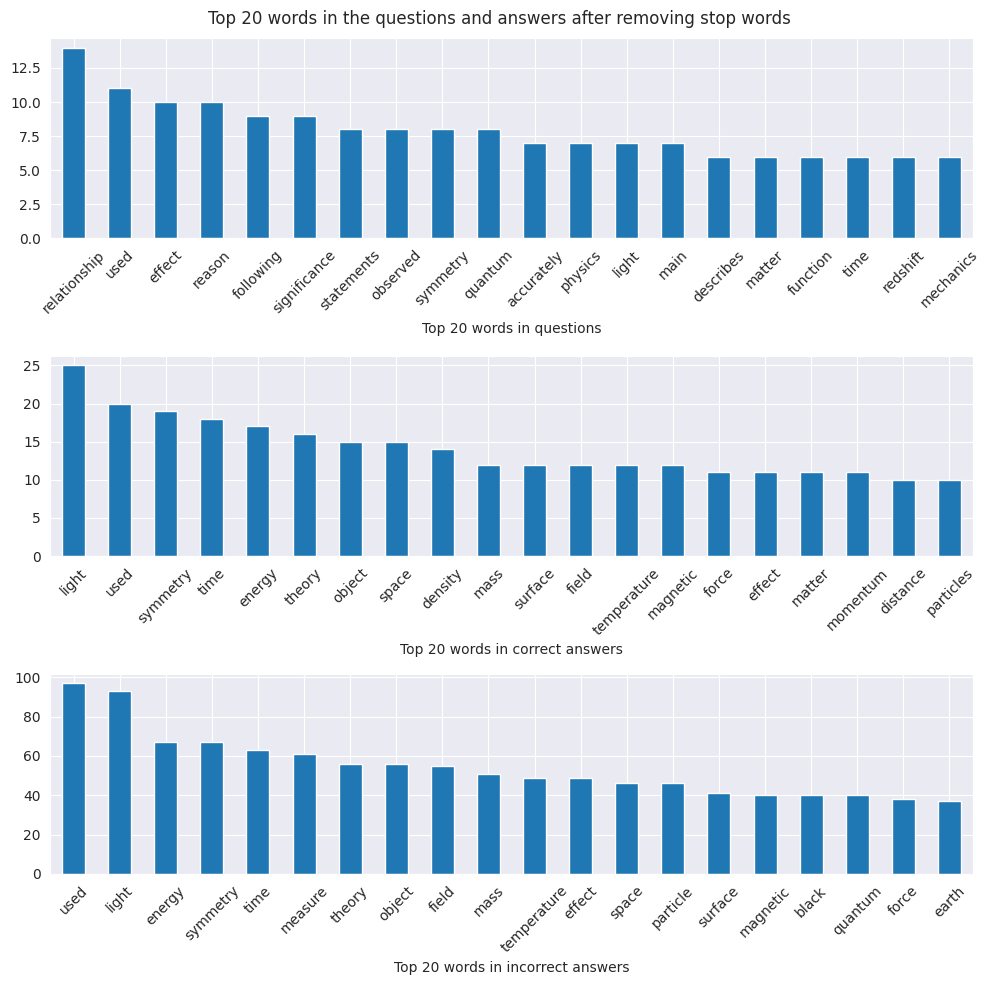

In [9]:
# The distribution of top unigrams after removing stop words for the questions and answers

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(3, figsize=(10,10))
    fig.suptitle('Top 20 words in the questions and answers after removing stop words')

    common_words = get_top_n_words(train_df['prompt'], 20)
    df2 = pd.DataFrame(common_words, columns = ['Question' , 'count'])
    df2.groupby('Question').sum()['count'].sort_values(ascending=False).plot(
        kind='bar', ax=axs[0])
    axs[0].set_xlabel('Top 20 words in questions')
    axs[0].set_xticklabels(df2['Question'], rotation = 45)

    common_words = get_top_n_words(correct_answers, 20)
    df3 = pd.DataFrame(common_words, columns = ['Correct Answers' , 'count'])
    df3.groupby('Correct Answers').sum()['count'].sort_values(ascending=False).plot(
        kind='bar', ax=axs[1])
    axs[1].set_xlabel('Top 20 words in correct answers')
    axs[1].set_xticklabels(df3['Correct Answers'], rotation = 45)

    common_words = get_top_n_words(incorrect_answers, 20)
    df4 = pd.DataFrame(common_words, columns = ['Incorrect Answers' , 'count'])
    df4.groupby('Incorrect Answers').sum()['count'].sort_values(ascending=False).plot(
        kind='bar', ax=axs[2])
    axs[2].set_xlabel('Top 20 words in incorrect answers')
    axs[2].set_xticklabels(df4['Incorrect Answers'], rotation = 45)
    fig.tight_layout()
plt.show()

In [10]:
# Create a scattertext plot of the answers
# Source: https://guides.library.upenn.edu/penntdm/python/scattertext#:~:text=scattertext%20is%20a%20free%2C%20open,scattertext%20creates%20scatterplots%20for%20text.
# Create nlp object
nlp = spacy.load("en_core_web_sm")

# Turn it into a Scattertext Corpus
corpus = st.CorpusFromPandas(answers_df,
                             category_col='Correctness',
                             text_col='Answer',
                             nlp=nlp).build()
# We print out the first 10 erms in the answers that differentiate the corpus from a general English corpus.
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))
# Then, we can print out terms are the terms that are most associated with the correct answers:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Correct Answers Score'] = corpus.get_scaled_f_scores('Correct Answers')
print(list(term_freq_df.sort_values(by='Correct Answers Score', ascending=False).index[:10]))

['tolerogenic', 'triskeles', 'antiquarks', 'memristor', 'memristive', 'memristors', 'tregs', 'reram', 'xnav', 'baos']
['can be', 'but', 'with the', 'or', 'be', 'as', 'is an', 'can', 'with', 'density']


In [11]:
# Create html visualization
html = st.produce_scattertext_explorer(corpus,
                                       category='Correct Answers',
                                       category_name='Correct',
                                       not_category_name='Incorrect',
                                       width_in_pixels=1000,
                                       metadata=answers_df['Question'])

# Open the html for interative visualization
# Please run the below code in your interactive window (like Python shell) if you do not see the HTML opening up
open("Convention-Visualization.html", 'wb').write(html.encode('utf-8'))

787256

In [12]:
# Scattertext created an html file of the plot, we can open it with IPython
IPython.display.HTML(filename='Convention-Visualization.html')

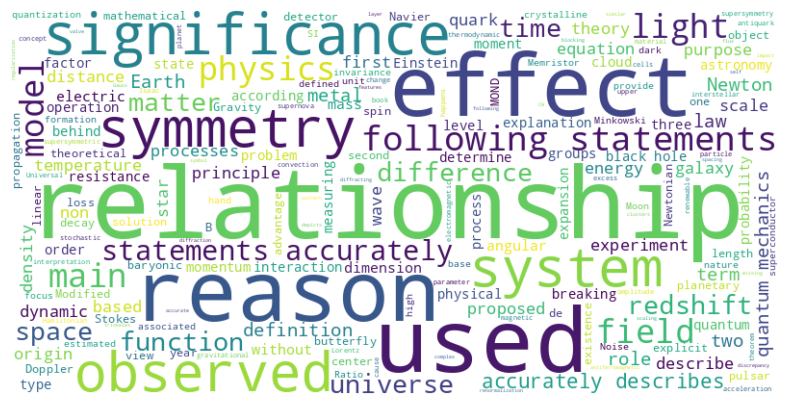

In [13]:
# Word cloud of questions
text_data = train_df['prompt'].dropna().str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

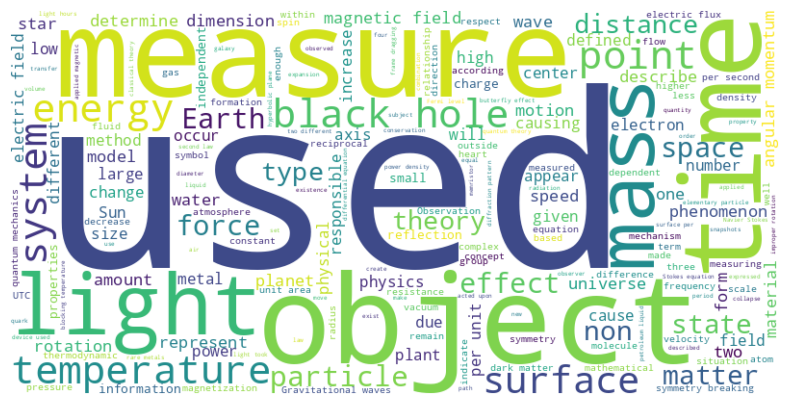

In [14]:
# Word cloud of answers
text_data = train_df[['A', 'B', 'C', 'D', 'E']].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1).str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
df = pd.DataFrame(train_df['prompt'])

# Define functions to categorize questions
def categorize_question_type(question):
    if re.search(r'\bWhat is\b', question, re.IGNORECASE):
        return 'What is'
    elif re.search(r'\bWhat are\b', question, re.IGNORECASE):
        return 'What are'
    elif re.search(r'\bWhat was\b', question, re.IGNORECASE):
        return 'What was'
    elif re.search(r'\bWhat did\b', question, re.IGNORECASE):
        return 'What did'
    elif re.search(r'\bWhat can\b', question, re.IGNORECASE):
        return 'What can'
    elif re.search(r'\bWhat does\b', question, re.IGNORECASE):
        return 'What does'
    elif re.search(r'\bWhat happens\b', question, re.IGNORECASE):
        return 'What happens'
    elif re.search(r'\bWhy\b', question, re.IGNORECASE):
        return 'Why'
    elif re.search(r'\bHow\b', question, re.IGNORECASE):
        return 'How'
    elif re.search(r'\bWhich\b', question, re.IGNORECASE):
        return 'Which'
    elif re.search(r'\bWho\b', question, re.IGNORECASE):
        return 'Who'
    else:
        print(question)
        return 'Other'

# Apply the function to categorize questions and create a new column 'question_type'
df['question_type'] = df['prompt'].apply(categorize_question_type)

# Count the questions by type
question_counts = df['question_type'].value_counts()

# Print the question counts
print(question_counts)

What is         160
Which            11
What are          9
Who               7
What did          4
What was          3
How               2
What happens      2
What does         1
What can          1
Name: question_type, dtype: int64


In [16]:
# Create a histogram of the types of questions
fig = px.histogram(df, x='question_type', nbins=10, text_auto=True)

# Rotate the x-axis ticks
#fig.update_layout(xaxis_tickangle=-30)

# Show the plot
fig.show()